# InvestBot: a bot for stock classification using fundamentalist analysis

## Solution Proposal

To solve the problem, we will follow these steps:

- **0.0.** Data Collection.
- **1.0.** Data Description.
- **2.0.** Feature Engineering
- **3.0.** Data Filtering
- **4.0.** Exploratory Data Analysis
- **5.0.** Data Preparation
- **6.0.** Feature Selection
- **7.0.** Machine Learning Modelling
- **8.0.** Hyperparameter Fine Tuning
- **9.0.** Machine Learning Performance
- **10.0.** Deploy Model to Production

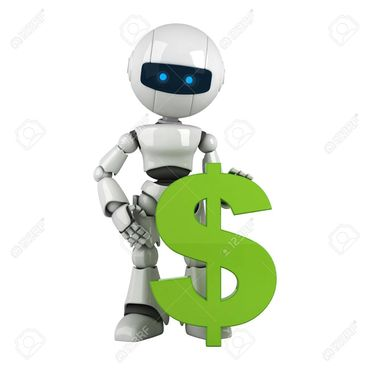

In [7]:
Image('img/bot.jpg')

# 0.0 Imports

In this section we will import the libraries needed to get the solution.

In [2]:
import pandas                      as pd
import numpy                       as np
import matplotlib.pyplot           as plt
import seaborn                     as sns
import plotly.express              as px
import os
import pickle
from sklearn.preprocessing         import StandardScaler, RobustScaler
from sklearn.ensemble              import ExtraTreesClassifier
from sklearn.model_selection       import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection     import SelectFromModel
from sklearn.dummy                 import DummyClassifier
from sklearn.metrics               import classification_report, confusion_matrix, make_scorer, precision_score
from sklearn.metrics               import recall_score, accuracy_score, f1_score
from sklearn.linear_model          import LogisticRegression
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.naive_bayes           import GaussianNB
from sklearn.neural_network        import MLPClassifier
from sklearn.ensemble              import RandomForestClassifier, AdaBoostClassifier
from imblearn.under_sampling       import RandomUnderSampler
from pandas_datareader             import data as web
from IPython.display               import Image
from boruta                        import BorutaPy
from joblib                        import dump, load


import warnings
warnings.filterwarnings("ignore")

## 0.1. Helper Functions

in this step, we'll document all the functions that will be used to solve the problem.

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    #plt.style.use( 'bmh' )
    #plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.2f' % x )
    
    sns.set()
    
def collect_balances( fundamentals, files, companies ):
    
    for file in files:
        # collecting only the company name
        name = file[:-4]

        # Balance Sheet
        balance = pd.read_excel( f'Balances/{file}', sheet_name=0 )

        # Name of the company as a title in the first column
        balance.iloc[0, 0] = name

        # Make the first line a header
        balance.columns = balance.iloc[0]
        balance = balance.iloc[1:]

        # Make the first column an index
        balance = balance.set_index( name )

        # Cash Flow Statement
        cfs = pd.read_excel( f'Balances/{file}', sheet_name=1 )

        # Name of the company as a title in the first column
        cfs.iloc[0, 0] = name

        # Make the first line a header
        cfs.columns = cfs.iloc[0]
        cfs = cfs.iloc[1:]

        # Make the first column an index
        cfs = cfs.set_index( name )

        try:
            fundamentals[name] = balance.append( cfs )
            companies.append( name )
        except:
            cfs.columns = balance.columns
            fundamentals[name] = balance.append( cfs )
            companies.append( name )
        else:
            pass
        
def read_quotes( quotes ):
    
    # getting the file name
    files = os.listdir( "Quotes" )
    
    for file in files:
        name = file[:-4]
        quotes[name] = pd.read_csv( f'Quotes/{file}' ) 
        
def show_missing_values( columns ):
    # Start dictionary with all keys equal to zero
    nan_values = dict.fromkeys( columns, 0 )
    total_lines = 0

    for company in fundamentals:
        tabel = fundamentals[company]
        # Total rows to know the proportion of missing values in each column
        total_lines += tabel.shape[0]

        for column in columns:
            qnt_nan = pd.isnull( tabel[column] ).sum()
            # Dictionary with the amount of nan values in each column
            nan_values[column] += qnt_nan
        
    return nan_values, total_lines

def transform_to_percentage_changes( df, verbose=True ):
    
    companies = list( df['Company'].unique() )
    
    for i, company in enumerate( companies ):
        df_aux = df.loc[df['Company'] == company]
        
        if verbose: 
            print( company )
            print( i )
        
        for column in df:
            if column in ['Company', 'Class']:
                continue
            
            conditions = [
                ( df_aux[column].shift( 1 ) == 0 ) & ( df_aux[column] > 0 ),
                ( df_aux[column].shift( 1 ) == 0 ) & ( df_aux[column] < 0 ),
                ( df_aux[column].shift( 1 ) == 0 ) & ( df_aux[column] == 0 )
            ]
            
            values = [1, -1, 0]
            
            df_aux[column] = np.select( conditions, values, default=df_aux[column].diff() / df_aux[column].abs().shift() )
            df.loc[df['Company'] == company, column] = df_aux[column]
    
    return df

def ml_metrics( y_test, y_pred, model_name ):
    print( f'Model: {model_name}' )
    
    report = classification_report( y_test, y_pred, target_names=['Not reliable', 'Reliable'] )
    print( report )
    
    cf_matrix = pd.DataFrame( confusion_matrix( y_test, y_pred ), index=['Not reliable', 'Reliable'], columns=['Not reliable', 'Reliable'] )
    sns.heatmap( cf_matrix, annot=True, cmap='Blues', fmt=',' )
    #plt.show()
    plt.savefig( 'img/dummy.png' )
    
def cross_validation( model, X_train, y_train, model_name ):
    
    precision2_score = make_scorer( precision_score, labels=[1], average='macro' )
    recall2_score = make_scorer( recall_score, labels=[1], average='macro' )
    f1_2_score = make_scorer( f1_score, labels=[1], average='macro' )
    
    accuracy = cross_val_score( model, X_train, y_train, cv=5, scoring='accuracy' )
    precision = cross_val_score( model, X_train, y_train, cv=5, scoring=precision2_score )
    recall = cross_val_score( model, X_train, y_train, cv=5, scoring=recall2_score )
    f1 = cross_val_score( model, X_train, y_train, cv=5, scoring=f1_2_score )
    
    return pd.DataFrame( {
      'Model': model_name,
      'Accuracy': np.round( np.mean( accuracy ), 2 ).astype( str ) + '+/-' + np.round( np.std( accuracy ), 2 ).astype( str ),
      'Precision': np.round( np.mean( precision ), 2 ).astype( str ) + '+/-' + np.round( np.std( precision ), 2 ).astype( str ),
      'Recall': np.round( np.mean( recall ), 2 ).astype( str ) + '+/-' + np.round( np.std( recall ), 2 ).astype( str ), 
      'F1': np.round( np.mean( f1 ), 2 ).astype( str ) + '+/-' + np.round( np.std( f1 ), 2 ).astype( str ) }, index = [0] )

In [4]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

### 0.2.1. Balance Sheet and Cash Flow Statement


In [59]:
# # Collect balance sheet and cash flow statement
# fundamentals = {}
# files = os.listdir( "Balances" )
# companies = []

# collect_balances( fundamentals, files, companies )

In [60]:
# # Saving balances sheets
# with open( "Data/Fundamentals_initial.pkl", "wb" ) as fund:
#     pickle.dump( fundamentals, fund )

In [227]:
# Importing the balances sheets
with open( "Data/Fundamentals_initial.pkl", "rb" ) as fund:
    fundamentals = pickle.load( fund )

### 0.2.2. Stock Quotes

In [62]:
# # Collect stock quotes
# quotes = {}

# for company in companies:
#     try:
#         quotes[company] = web.DataReader( f'{company}.SA', data_source='yahoo', start="06/30/2011", end="09/30/2021" )
#     except:
#         pass

In [63]:
# # Saving quotes
# for company in quotes:
#     quotes[company].to_csv( f'Quotes/{company}.csv' )

In [228]:
# Read stock quotes
quotes = {}
read_quotes( quotes )

### 0.2.2. Remove companies from the fundamentals that do not have quotes for the period collected

In [229]:
companies = list( fundamentals.keys() )

for company in companies:
    if company not in quotes:
        fundamentals.pop( company )

companies = list( quotes.keys() )

### 0.2.3. Remove companies that have empty quotes

In [230]:
for company in companies:
    if quotes[company].isnull().values.any():
        quotes.pop( company )
        fundamentals.pop( company )

companies = list( quotes.keys() )

### 0.2.4. Adding dates that don't exist in the quotes 

In [231]:
# Adding dates for quarters that do not exist in quote dataframes
for company in companies:
    # Putting quote date as dataframe index
    quotes[company] = quotes[company].set_index( "Date" )
    first_date = quotes[company].index[0].split( '-' )
    last_date = quotes[company].index[-1].split( '-' )
    
    for date in fundamentals[company].columns:
        try:
            date_aux = date.split( '/' )
        except:
            continue
        
        if datetime.date( int( date_aux[2] ), int( date_aux[1] ), int( date_aux[0] ) ) <= datetime.date( int( last_date[0] ), int( last_date[1] ), int( last_date[2] ) ) and datetime.date( int( date_aux[2] ), int( date_aux[1] ), int( date_aux[0] ) ) >= datetime.date( int( first_date[0] ), int( first_date[1] ), int( first_date[2] ) ):
            formatted_date = date_aux[2] + '-' + date_aux[1] + '-' + date_aux[0]
            # Inserting new lines with empty fields
            if formatted_date not in list( quotes[company].index ):
                quotes[company].loc[formatted_date] = np.nan

# Sorting the df and filling the created fields
for company in quotes:
    # sorting by date
    quotes[company] = quotes[company].sort_index()
    
    # filling empty fields with data from the previous row
    quotes[company] = quotes[company].ffill()


In [232]:
for company in quotes:
    quotes[company] = quotes[company].reset_index()
    quotes[company]['Date'] = pd.to_datetime( quotes[company]['Date'] )
    quotes[company]['Date'] = quotes[company]['Date'].dt.strftime( "%d/%m/%Y" )
    quotes[company] = quotes[company].set_index( 'Date' )
    quotes[company].index = pd.to_datetime( quotes[company].index, format="%d/%m/%Y" )

### 0.2.4. Joining the fundamentals and the quotes

In [233]:
for company in fundamentals:
    # Fundamentals
    # Turn rows into columns
    table = fundamentals[company].T
    
    # Transform index to date type
    table.index = pd.to_datetime( table.index, format="%d/%m/%Y" )
    
    # Quotes
    quote_table = quotes[company]
    
    # Select only the column Adj Close
    quote_table = quote_table[['Adj Close']]
    
    # Merge
    table = table.merge( quote_table, right_index=True, left_index=True )
    
    # Inserting name in index column
    table.index.name = company
    
    fundamentals[company] = table

### 0.2.5. Removing empty dataframes

In [234]:
companies = list( fundamentals.keys() )

for company in companies:
    if len( fundamentals[company] ) == 0:
        fundamentals.pop( company )

### 0.2.6. Treat columns

- Catch only companies that have the same columns
- Columns with repeated names
- Missing values
- Create a column with the name of the companies

**1. Catch only companies that have the same columns**

In [235]:
columns = list ( fundamentals['PETR4'].columns )
companies = list( fundamentals.keys() )

for company in companies:
    # Checking if the company has the necessary columns
    if set( columns ) != set( fundamentals[company].columns ):
        fundamentals.pop( company )

**2. Columns with repeated names**

In [236]:
# Changing the name of columns that have the same names
text_columns = ";".join( columns )

modified_columns = []
for column in columns:
    if columns.count( column ) == 2 and column not in modified_columns:
        text_columns = text_columns.replace( ";" + column + ";", ";" + column + "_1;", 1 )
        modified_columns.append( column )
        
columns = text_columns.split( ';' )

In [237]:
# Implement columns in tables
for company in fundamentals:
    fundamentals[company].columns = columns

**3. Missing values**

In [238]:
# Counting the total number of missing values in each column
nan_values, total_lines = show_missing_values( columns )
        
print( nan_values )
print( total_lines )

{'Ativo Total': 0, 'Ativo Circulante': 0, 'Caixa e Equivalentes de Caixa': 0, 'Aplicações Financeiras': 0, 'Contas a Receber_1': 0, 'Estoques_1': 0, 'Ativos Biológicos_1': 0, 'Tributos a Recuperar': 0, 'Despesas Antecipadas_1': 0, 'Outros Ativos Circulantes': 0, 'Ativo Realizável a Longo Prazo': 0, 'Aplicações Financeiras Avaliadas a Valor Justo': 0, 'Aplicações Financeiras Avaliadas ao Custo Amortizado': 0, 'Contas a Receber': 0, 'Estoques': 0, 'Ativos Biológicos': 0, 'Tributos Diferidos_1': 0, 'Despesas Antecipadas': 0, 'Créditos com Partes Relacionadas': 0, 'Outros Ativos Não Circulantes': 0, 'Investimentos': 0, 'Imobilizado': 0, 'Intangível': 0, 'Diferido': 0, 'Passivo Total': 0, 'Passivo Circulante': 0, 'Obrigações Sociais e Trabalhistas': 0, 'Fornecedores': 0, 'Obrigações Fiscais': 0, 'Empréstimos e Financiamentos_1': 0, 'Passivos com Partes Relacionadas_1': 0, 'Dividendos e JCP a Pagar': 0, 'Outros_1': 0, 'Provisões_1': 0, 'Passivos sobre Ativos Não-Correntes a Venda e Descontin

In [239]:
# Remove columns longer than 50 rows with nan values
delete_columns = []

for column in nan_values:
    if nan_values[column] > 50:
        delete_columns.append( column )
        
for company in fundamentals:
    fundamentals[company] = fundamentals[company].drop( delete_columns, axis=1 )
    fundamentals[company] = fundamentals[company].ffill()

**4. Create a column with the name of the companies**

In [240]:
for company in fundamentals:
    fundamentals[company].loc[:, 'Company'] = fundamentals[company].index.name

### 0.2.6. Creating labels: reliable or not reliable

**Rules:**

    1. The stock yielded 3% or more = reliable - Value 1
    2. The stock yielded lower than 3% = not reliable - Value 0

In [68]:
# transform quotes into percentages
# quarter quotes - next quarter quote / quarter quote - 1

for company in fundamentals:
    indicator = fundamentals[company]
    indicator = indicator.sort_index()
    
    # get next indicator
    indicator['Perc'] = ( indicator['Adj Close'].shift( -1 ) / indicator['Adj Close'] ) -1                                                                    
    indicator['Class'] = indicator['Perc'].map( lambda x: 1 if x >= 0.03 else 0 ) 
        
    fundamentals[company] = indicator

### 0.2.7. Making everything a single dataframe

In [70]:
# with open( "Data/Fundamentals_final.pkl", "wb" ) as fund:
#     pickle.dump( fundamentals, fund )

In [9]:
# with open( "Data/Fundamentals_final.pkl", "rb" ) as fund:
#     fundamentals = pickle.load( fund )

In [11]:
# Saving train and test datasets
df = pd.DataFrame()

for company in fundamentals:
    fundamentals[company] = fundamentals[company][:-1]
    fundamentals[company] = fundamentals[company].reset_index( drop=True )
    df = df.append( fundamentals[company] )
    
df.to_csv('Data/Fundamentals.csv', index=False )

# 1.0. Data Description

in this step we will perform the following tasks:

- Data Dimensions
- Data Types
- Change data types
- Check missing values
- Descriptive Statistical

This step is very important for us to know how challenging the problem is.

In [5]:
#Importing 
df_raw = pd.read_csv( 'Data/Fundamentals.csv' )

# Reading the dataset of the number of papers available
df_qnt = pd.read_csv( 'Data/quantity.csv' )

# merge
df1 = pd.merge( df_raw, df_qnt, how='inner', on=['Company'] )

In [7]:
df1.head()

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,Ativo Realizável a Longo Prazo,Aplicações Financeiras Avaliadas a Valor Justo,Aplicações Financeiras Avaliadas ao Custo Amortizado,Contas a Receber,Estoques,Ativos Biológicos,Tributos Diferidos_1,Despesas Antecipadas,Créditos com Partes Relacionadas,Outros Ativos Não Circulantes,Investimentos,Imobilizado,Intangível,Diferido,Passivo Total,Passivo Circulante,Obrigações Sociais e Trabalhistas,Fornecedores,Obrigações Fiscais,Empréstimos e Financiamentos_1,Passivos com Partes Relacionadas_1,Dividendos e JCP a Pagar,Outros_1,Provisões_1,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados_1,Passivo Não Circulante,Empréstimos e Financiamentos,Passivos com Partes Relacionadas,Outros,Tributos Diferidos,Adiantamento para Futuro Aumento Capital_1,Provisões,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados,Lucros e Receitas a Apropriar,Participação dos Acionistas Não Controladores,Patrimônio Líquido,Capital Social Realizado,Reservas de Capital,Reservas de Reavaliação,Reservas de Lucros,Lucros/Prejuízos Acumulados,Ajustes de Avaliação Patrimonial,Ajustes Acumulados de Conversão,Outros Resultados Abrangentes,Adiantamento para Futuro Aumento Capital,Receita Líquida de Vendas e/ou Serviços,Custo de Bens e/ou Serviços Vendidos,Resultado Bruto,Despesas Com Vendas,Despesas Gerais e Administrativas,Perdas pela Não Recuperabilidade de Ativos,Outras Receitas Operacionais,Outras Despesas Operacionais,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Lucro/Prejuízo do Período,Adj Close,Company,Perc,Class,quantity
0,2166311.94,494428.99,159332.99,37811.00,233260.00,6391.00,0.00,26373.00,0.00,31261.00,324902.02,5696.00,0.00,893.00,0.00,0.00,61530.00,0.00,31114.00,225668.99,4694.00,464206.02,878081.02,0,2166311.94,404579.01,41227.00,69737.00,35813.00,202830.00,0.00,0.00,54972.00,0.00,0.00,549798.02,302816.99,293.00,62758.00,4452.00,0,179478.00,0.00,0.00,38335.00,1173599.98,579779.97,611692.03,0.00,0.00,-17872.00,0.00,0.00,0.00,0,258976.02,-170078.99,88897.01,0.00,-77397.01,0.00,0.00,8184.00,2848.00,-17779.00,-6715.00,27243.00,4753.00,-24193.00,18341.00,16071.00,14.50,AALR3,0.07,1,118293000
1,2218670.08,384152.99,53505.00,0.00,249166.00,6222.00,0.00,35818.00,0.00,39442.00,354574.02,5657.00,0.00,910.00,0.00,0.00,90051.00,0.00,26632.00,231324.00,5536.00,507017.98,967388.99,0,2218670.08,429271.01,42940.00,56803.00,44106.00,208758.00,0.00,0.00,76664.00,0.00,0.00,564988.99,275329.98,235.00,79435.00,31127.00,0,178862.00,0.00,0.00,41505.00,1182904.98,580094.98,616337.98,0.00,0.00,-12086.00,0.00,0.00,-1442.00,0,259276.99,-182804.00,76473.00,0.00,-53506.00,0.00,0.00,-1513.00,3469.00,-9791.00,0.00,0.00,15132.00,-8911.00,2541.00,5786.00,15.47,AALR3,0.12,1,118293000
2,2270885.12,409799.01,51155.00,0.00,263584.00,5768.00,0.00,45282.00,0.00,44010.00,349079.01,5349.00,0.00,0.00,0.00,0.00,93697.00,0.00,31586.00,218447.01,4861.00,537486.98,969659.01,0,2270885.12,471113.98,44836.00,66345.00,53246.00,230071.01,0.00,0.00,76616.00,0.00,0.00,539440.00,267424.00,0.00,75660.00,36040.00,0,160316.00,0.00,0.00,41987.00,1218344.01,612313.02,615328.00,0.00,0.00,-8132.00,0.00,0.00,-1165.00,0,270404.99,-184524.00,85881.00,0.00,-56365.00,0.00,0.00,-1099.00,3466.00,-21992.00,0.00,0.00,9891.00,-2722.00,-2431.00,3954.00,17.36,AALR3,-0.03,0,118293000
3,2308239.10,430387.01,50806.00,0.00,282444.00,5983.00,0.00,49081.00,0.00,42073.00,361828.00,5468.00,0.00,0.00,0.00,0.00,98079.00,0.00,34298.00,223983.01,5706.00,537744.00,972574.02,0,2308239.10,512652.99,49926.00,72763.00,52389.00,267888.00,0.00,0.00,69687.00,0.00,0.00,520856.99,246075.01,3098.00,75340.00,41166.00,0,155178.00,0.00,0.00,44344.00,1230384.96,612425.98,617659.01,0.00,2057.00,0.00,

## 1.1. Data Dimensions

In [8]:
print( f'Number of rows: {df1.shape[0]}' )
print( f'Number of columns: {df1.shape[1]}' )

Number of rows: 15254
Number of columns: 76


## 1.2. Data Types

In [9]:
df1.dtypes

Ativo Total                                                       float64
Ativo Circulante                                                  float64
Caixa e Equivalentes de Caixa                                     float64
Aplicações Financeiras                                            float64
Contas a Receber_1                                                float64
Estoques_1                                                        float64
Ativos Biológicos_1                                               float64
Tributos a Recuperar                                              float64
Despesas Antecipadas_1                                            float64
Outros Ativos Circulantes                                         float64
Ativo Realizável a Longo Prazo                                    float64
Aplicações Financeiras Avaliadas a Valor Justo                    float64
Aplicações Financeiras Avaliadas ao Custo Amortizado              float64
Contas a Receber                      

## 1.3. Check NA

In [10]:
df1.isna().sum().sort_values( ascending=False )

Resultado Bruto                                                   3
Receitas Financeiras                                              3
Receita Líquida de Vendas e/ou Serviços                           3
Custo de Bens e/ou Serviços Vendidos                              3
Despesas Com Vendas                                               3
Despesas Gerais e Administrativas                                 3
Perdas pela Não Recuperabilidade de Ativos                        3
Outras Receitas Operacionais                                      3
Outras Despesas Operacionais                                      3
Financeiras                                                       3
Resultado da Equivalência Patrimonial                             3
Despesas Financeiras                                              3
Resultado Antes Tributação/Participações                          3
Provisão para IR e Contribuição Social                            3
IR Diferido                                     

## 1.4. Fillout Na

In [11]:
df1.dropna( inplace=True )

## 1.5. Descriptive Statistical

We will use two types of analysis:

- Central tendency
    - average
    - median
- Dispersion 
    - std - standard deviation
    - min
    - max
    - range
    - skew
    - kurtosis

In [12]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Ativo Total,0.00,1015142023.17,1015142023.17,16037918.09,2831793.92,67509713.69,10.29,121.10
1,Ativo Circulante,0.00,292852989.95,292852989.95,4421351.71,879148.99,14553750.68,9.11,107.86
2,Caixa e Equivalentes de Caixa,-30.00,106597998.59,106598028.59,1085982.07,95499.00,4964076.37,12.27,179.91
3,Aplicações Financeiras,0.00,142760001.54,142760001.54,638059.73,7379.00,3966006.70,24.60,739.90
4,Contas a Receber_1,0.00,115283001.34,115283001.34,1106687.80,232114.00,3905315.96,14.96,306.51
5,Estoques_1,-968.00,39729999.87,39730967.87,759178.75,35966.00,2863457.08,7.88,76.33
6,Ativos Biológicos_1,0.00,6490744.83,6490744.83,15809.50,0.00,181852.60,18.29,437.35
7,Tributos a Recuperar,0.00,29788000.26,29788000.26,232977.75,18575.00,1021469.71,11.70,197.36
8,Despesas Antecipadas_1,0.00,2270287.10,2270287.10,17280.50,0.00,101787.78,12.79,200.54
9,Outros Ativos Circulantes,-85.00,56051998.72,56052083.72,565222.49,25230.00,2666758.87,8.46,88.81


It seems that some lines have abnormal values, and this may affect the performance of our models. So, let's check which lines have these values, to eliminate them later.

In [130]:
list( df1.loc[df1['Adj Close'] == df1['Adj Close'].min(), 'Company'] )[0] 

'MMAQ3'

In [180]:
list( df1.loc[df1['Adj Close'] == df1['Adj Close'].max(), 'Company'] )[0]

'MMAQ3'

**The Company *MMAQ3* has abnormal values, and will be excluded from the dataset in section 3.0.**

# 2.0. Feature Engineering

In [13]:
df2 = df1.copy()

In [14]:
# Liquidez Corrente
df2['Liquidez Corrente'] = df2[['Ativo Circulante', 'Passivo Circulante']].apply( lambda x: 0 if x['Passivo Circulante'] == 0 
                                                                else x['Ativo Circulante'] / x['Passivo Circulante'], axis=1 )
# LPA
df2['LPA'] = df2['Lucro/Prejuízo do Período'] / df2['quantity'] 

# P/L
df2['P/L'] = df2[['Adj Close', 'LPA']].apply( lambda x: 0 if x['LPA'] == 0 else x['Adj Close'] / x['LPA'], axis=1 )

# VPA
df2['VPA'] = df2['Patrimônio Líquido'] / df2['quantity']

# P/VP 
df2['P/VP'] = df2[['Adj Close', 'VPA']].apply( lambda x: 0 if x['VPA'] == 0 else x['Adj Close'] / x['VPA'], axis=1 )

# EBIT - NAO TEM!!
df2['EBIT'] = df2['Receita Líquida de Vendas e/ou Serviços'] - df2['Custo de Bens e/ou Serviços Vendidos'] - ( df2['Despesas Com Vendas'] + df2['Despesas Gerais e Administrativas'] )

# EV/EBIT - NAO TEM!!!!
df2['EV/EBIT'] = df2[['Adj Close', 'quantity', 'Empréstimos e Financiamentos_1', 'Ativo Circulante', 'EBIT']].apply( lambda x: 0 
                                                    if x['EBIT'] == 0 else ( ( x['Adj Close'] * x['quantity'] ) 
                                                                            + ( x['Empréstimos e Financiamentos_1'] 
                                                                            - x['Ativo Circulante'] ) ) 
                                                                            / x['EBIT'] , axis=1 )
# NOPLAT - NAO TEM!!!!
df2['NOPLAT'] = df2['EBIT'] - df2['IR Diferido']

# ROIC - NAO TEM!!!!
df2['ROIC'] = df2[['NOPLAT', 'Investimentos']].apply( lambda x: 0 if x['Investimentos'] == 0 else x['NOPLAT'] / x['Investimentos'], axis=1 )

# ROE
df2['ROE'] = df2[['Reservas de Lucros', 'Patrimônio Líquido']].apply( lambda x: 0 
                                                if x['Patrimônio Líquido'] == 0 
                                                else x['Reservas de Lucros'] / x['Patrimônio Líquido'], axis=1 )

# Pay-Out
df2['Pay-Out'] = df2[['Dividendos e JCP a Pagar', 'Lucro/Prejuízo do Período']].apply( lambda x: 0 
                                   if x['Lucro/Prejuízo do Período'] == 0 
                                   else ( x['Dividendos e JCP a Pagar'] / x['Lucro/Prejuízo do Período'] ) * 100, axis=1 )

# Dividend Yield
df2['Dividend Yield'] = ( ( df2['Dividendos e JCP a Pagar'] / df2['quantity'] ) / df2['Adj Close'] ) * 100

# Marg. Ebit - NAO TEM!!!!
df2['MargEbit'] = df2[['EBIT', 'Receita Líquida de Vendas e/ou Serviços']].apply( lambda x: 0 
                                                        if x['Receita Líquida de Vendas e/ou Serviços'] == 0 
                                                        else x['EBIT'] / x['Receita Líquida de Vendas e/ou Serviços'], axis=1 )

# Marg. Liquida 
df2['MargLiquida'] = df2[['Lucro/Prejuízo do Período', 'Receita Líquida de Vendas e/ou Serviços']].apply( lambda x: 0 
                                  if x['Receita Líquida de Vendas e/ou Serviços'] == 0 
                                  else x['Lucro/Prejuízo do Período'] / x['Receita Líquida de Vendas e/ou Serviços'], axis=1 )

# P/Ebit 
df2['P/Ebit'] = df2[['Adj Close', 'EBIT']].apply( lambda x: 0 if x['EBIT'] == 0 else x['Adj Close'] / x['EBIT'], axis=1 )

# PSR
df2['PSR'] = df2[['Adj Close', 'Receita Líquida de Vendas e/ou Serviços', 'quantity']].apply( lambda x: 0 
                                if x['Receita Líquida de Vendas e/ou Serviços'] == 0 
                                else x['Adj Close'] / ( x['Receita Líquida de Vendas e/ou Serviços'] / x['quantity'] ), axis=1 )

# P/Ativos
df2['P/Ativos'] = df2[['Adj Close', 'Ativo Total', 'quantity']].apply( lambda x: 0 if x['Ativo Total'] == 0 
                                                            else x['Adj Close'] / ( x['Ativo Total'] / x['quantity'] ), axis=1 )

# Giro do Ativo Total
df2.loc[:, 'GA'] = df2[['Receita Líquida de Vendas e/ou Serviços', 'Ativo Total']].apply( lambda x: 0 if x['Ativo Total'] == 0
                                                                           else x['Receita Líquida de Vendas e/ou Serviços'] / x['Ativo Total'], axis=1 )

# ROA - Retorno do Ativo Total
df2.loc[:, 'ROA'] = df2[['Lucro/Prejuízo do Período', 'Ativo Total']].apply( lambda x: 0 if x['Ativo Total'] == 0
                                                                           else  x['Lucro/Prejuízo do Período'] / x['Ativo Total'], axis=1 )

# 3.0. Data Filtering

In [15]:
df3 = df2.copy()

In this section, we'll filter out the rows and columns that are not needed or that could damage the model training. Therefore, we will separate this step into two:

**1.** Filtering Rows

**2.** Filtering Columns

## 3.1. Filtering Rows

As previously stated, here we will filter the lines of company **MMAQ3**, which have abnormal values. Also, we will also remove the lines that have the negative quotes, after all, it makes no sense for a quote to have a price lower than 0, right

In [16]:
df3 = df3.loc[ ( df3['Company'] != 'MMAQ3' ) & ( df3['Company'] != 'MMAQ4' ) &
               ( df3['Company'] != 'VSPT3' ) & ( df3['Adj Close'] > 0 ) ]   

## 3.2. Filtering Columns

Now, we are going to delete some columns that are no longer needed. These will be:

**1.** Adj Close - The quotes column was used only to label the stocks. However, right now, it will not help us.

**2.** quantity - the quantity of papers was useful to create other features, however, it will not be necessary to create the model.

In [17]:
df3.drop( ['Perc', 'quantity', 'Adj Close'], axis=1, inplace=True )

# 4.0.Exploratory Data Analysis

In [18]:
df4 = df3.copy()

In this section, in order to become more familiar with our data, we will have to perform some simple Exploratory Data Analysis. We do this to better understand our data and make sure there are no lingering issues we may have missed when we transformed the data. So let’s begin coding it out with some visualizations.

## 4.1. Response Variable

0    59.01%
1    40.99%
Name: Class, dtype: object


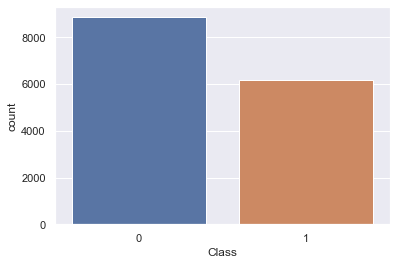

In [19]:
print( df4['Class'].value_counts( normalize=True ).map( "{:.2%}".format ) )
sns.countplot( x=df4['Class'] );
plt.savefig('img/response_variable.png')

## 4.2. Multivariate Analysis

In [20]:
# transform
df4 = transform_to_percentage_changes( df4, verbose=False )

# Delete Nan values
df4.dropna( inplace=True )

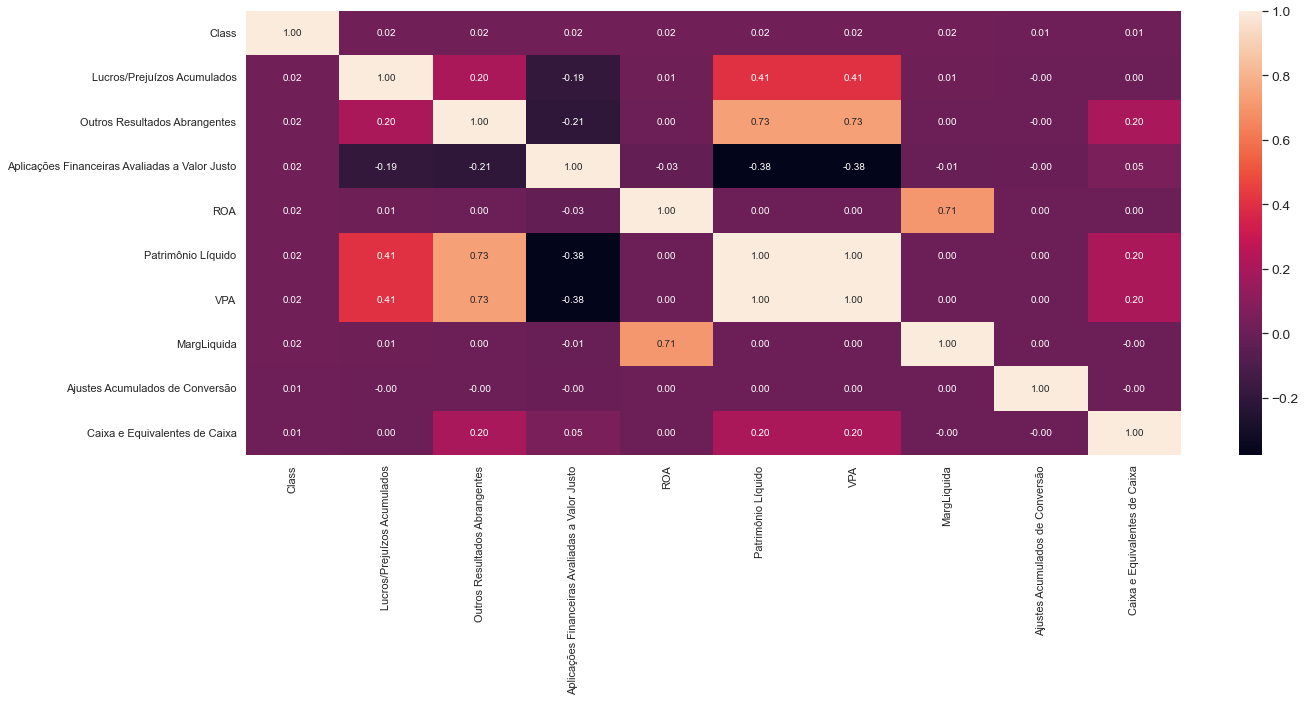

In [21]:
# correlations
k = 10
df_corr = df4.corr()
cols = df_corr.nlargest( k, 'Class' )['Class'].index
cm = np.corrcoef( df4[cols].values.T )

fig, ax = plt.subplots( figsize=( 20, 10 ) )
sns.set( font_scale=1.25 )
hm = sns.heatmap( cm, cbar=True, annot=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values,  xticklabels=cols.values )
plt.tight_layout()
plt.savefig( 'img/correlations.png' )

In [100]:
df4_aux['Date'] = df4['Date']

# 5.0. Data Preparation

In [36]:
df5 = df4.copy()

## 5.1. Split dataframe into training and validation

In [220]:
# df5.to_csv( 'data/df5.csv', index=False )
df5 = pd.read_csv( 'data/df5.csv' )

In [221]:
df5.drop( 'Company', axis=1, inplace=True )

# Features
X = df5.drop( 'Class', axis=1 )

# Response Variable
y = df5['Class']

# split data in training and validation dataset - Hold-Out
X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size=0.3, stratify=y, shuffle=True, random_state=13 )

## 5.2. Rescaling

In [222]:
rs = RobustScaler()

aux01 = rs.fit_transform( X_train )
X_train = pd.DataFrame( aux01, X_train.index, X_train.columns ) 
pickle.dump( rs, open( 'parameter/scaler.pkl', 'wb' ) )

aux02 = rs.fit_transform( X_valid )
X_valid = pd.DataFrame( aux02, X_valid.index, X_valid.columns ) 

# 6.0. Feature Selection

## 6.1. Boruta as Feature Selector

In [40]:
# # training and test dataset for Boruta
# X_train_n = X_train.values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestClassifier( n_jobs=-1 )

# # define boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=13 ).fit( X_train_n, y_train_n )

In [41]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [42]:
cols_selected_boruta

['Ativo Total',
 'Caixa e Equivalentes de Caixa',
 'Imobilizado',
 'Passivo Total',
 'Patrimônio Líquido',
 'Lucros/Prejuízos Acumulados',
 'Financeiras',
 'P/L',
 'VPA',
 'P/VP',
 'MargEbit',
 'P/Ativos']

In [12]:
# cols_selected_boruta = ['Ativo Total',
#  'Caixa e Equivalentes de Caixa',
#  'Imobilizado',
#  'Passivo Total',
#  'Patrimônio Líquido',
#  'Lucros/Prejuízos Acumulados',
#  'Financeiras',
#  'P/L',
#  'VPA',
#  'P/VP',
#  'MargEbit',
#  'P/Ativos']

cols_selected_boruta_final = ['Ativo Total',
 'Caixa e Equivalentes de Caixa',
 'Imobilizado',
 'Passivo Total',
 'Patrimônio Líquido',
 'Lucros/Prejuízos Acumulados',
 'Financeiras',
 'P/L',
 'VPA',
 'P/VP',
 'MargEbit',
 'P/Ativos']

X_train = X_train.loc[:, cols_selected_boruta_final]
X_valid = X_valid.loc[:, cols_selected_boruta_final]

# 7.0. Machine Learning Modeling

Logistic Regression, Decision Tree, K-Nearest Neighbors, Naive Bayes, Multilayer Perceptron and Random Forest

## 7.1. Baseline

Model: Dummy
              precision    recall  f1-score   support

Not reliable       0.57      0.57      0.57      2559
    Reliable       0.40      0.40      0.40      1821

    accuracy                           0.50      4380
   macro avg       0.49      0.49      0.49      4380
weighted avg       0.50      0.50      0.50      4380



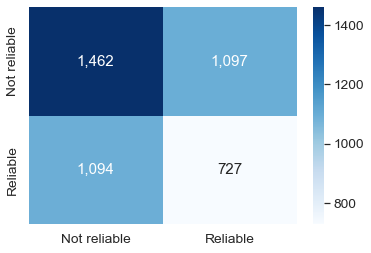

In [62]:
# Hold-out
dummy = DummyClassifier( strategy='stratified', random_state=13 )
dummy.fit( X_train, y_train )
dummy_pred = dummy.predict( X_valid )

ml_metrics( y_valid, dummy_pred, "Dummy" )

In [63]:
# Cross Validation
dummy = DummyClassifier( strategy='stratified', random_state=13 )

dummy_cv = cross_validation( dummy, X, y, 'Dummy' )
dummy_cv

,Model,Accuracy,Precision,Recall,F1
0,Dummy,0.52+/-0.0,0.42+/-0.0,0.43+/-0.0,0.42+/-0.0


## 7.2. Logistic Regression

Model: Logistic Regression
              precision    recall  f1-score   support

Not reliable       0.58      1.00      0.74      2559
    Reliable       0.86      0.00      0.01      1821

    accuracy                           0.59      4380
   macro avg       0.72      0.50      0.37      4380
weighted avg       0.70      0.59      0.43      4380



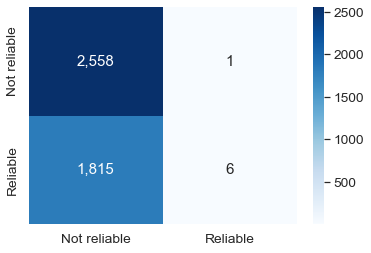

In [60]:
lr = LogisticRegression( random_state=13 )
lr.fit( X_train, y_train )
lr_pred = lr.predict( X_valid )

ml_metrics( y_valid, lr_pred, 'Logistic Regression' )

In [61]:
# Cross Validation
lr = LogisticRegression( random_state=13 )

lr_cv = cross_validation( lr, X, y, 'Logistic Regression' )
lr_cv

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.54+/-0.02,0.44+/-0.02,0.38+/-0.03,0.41+/-0.02


## 7.3. Decision Tree

Model: Decision Tree
              precision    recall  f1-score   support

Not reliable       0.64      0.63      0.64      2559
    Reliable       0.49      0.51      0.50      1821

    accuracy                           0.58      4380
   macro avg       0.57      0.57      0.57      4380
weighted avg       0.58      0.58      0.58      4380



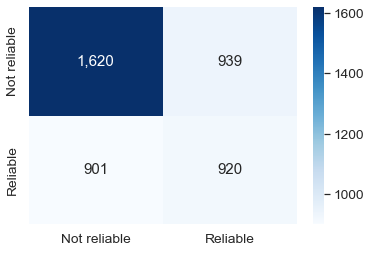

In [58]:
dt = DecisionTreeClassifier( random_state=13 )
dt.fit( X_train, y_train )
dt_prev = dt.predict( X_valid )
ml_metrics( y_valid, dt_prev, 'Decision Tree' )

In [59]:
# Cross Validation
dt = DecisionTreeClassifier( random_state=13 )
dt_cv = cross_validation( dt, X, y, 'Decision Tree' )
dt_cv

,Model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.52+/-0.01,0.42+/-0.01,0.43+/-0.03,0.43+/-0.02


## 7.4. K-Nearest Neighbors

Model: K-Nearest Neighbors
              precision    recall  f1-score   support

Not reliable       0.63      0.69      0.66      2559
    Reliable       0.50      0.44      0.46      1821

    accuracy                           0.58      4380
   macro avg       0.56      0.56      0.56      4380
weighted avg       0.57      0.58      0.58      4380



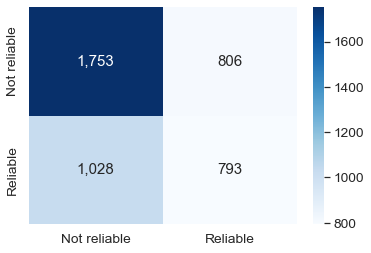

In [56]:
knn = KNeighborsClassifier()
knn.fit( X_train, y_train )
knn_prev = knn.predict( X_valid )
ml_metrics( y_valid, knn_prev, "K-Nearest Neighbors" )

In [57]:
# Cross Validation
knn = KNeighborsClassifier()
knn_cv = cross_validation( knn, X, y, "K-Nearest Neighbors" )
knn_cv

,Model,Accuracy,Precision,Recall,F1
0,K-Nearest Neighbors,0.55+/-0.0,0.45+/-0.01,0.39+/-0.03,0.42+/-0.02


## 7.5. Naive Bayes

Model: Naive Bayes
              precision    recall  f1-score   support

Not reliable       0.59      0.01      0.02      2559
    Reliable       0.42      0.99      0.59      1821

    accuracy                           0.42      4380
   macro avg       0.50      0.50      0.30      4380
weighted avg       0.52      0.42      0.26      4380



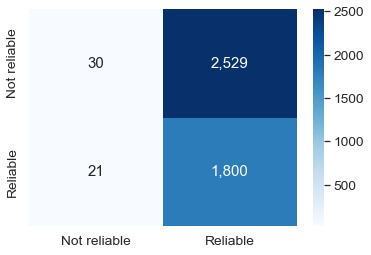

In [54]:
nb = GaussianNB()
nb.fit( X_train, y_train )
nb_pred = nb.predict( X_valid )
ml_metrics( y_valid, nb_pred, "Naive Bayes" )

In [55]:
# Cross Validation
nb = GaussianNB()
nb_cv = cross_validation( nb, X, y, "Naive Bayes" )
nb_cv

,Model,Accuracy,Precision,Recall,F1
0,Naive Bayes,0.42+/-0.0,0.42+/-0.0,0.97+/-0.01,0.58+/-0.0


## 7.6. Multilayer Perceptron

Model: Multilayer Perceptron
              precision    recall  f1-score   support

Not reliable       0.60      0.79      0.68      2559
    Reliable       0.47      0.26      0.33      1821

    accuracy                           0.57      4380
   macro avg       0.54      0.53      0.51      4380
weighted avg       0.55      0.57      0.54      4380



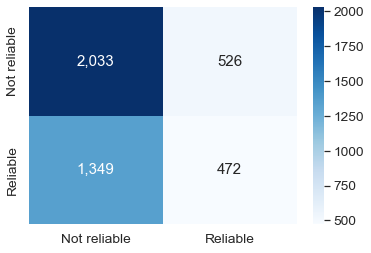

In [52]:
mlp = MLPClassifier( random_state=13 )
mlp.fit( X_train, y_train )
mlp_pred = mlp.predict( X_valid )
ml_metrics( y_valid, mlp_pred, "Multilayer Perceptron" )

In [53]:
# Cross Validation
mlp = MLPClassifier( random_state=13 )
mlp_cv = cross_validation( mlp, X, y, 'Multilayer Perceptron' )
mlp_cv

,Model,Accuracy,Precision,Recall,F1
0,Multilayer Perceptron,0.56+/-0.01,0.44+/-0.01,0.23+/-0.04,0.3+/-0.04


## 7.7. Random Forest

Model: Random Forest
              precision    recall  f1-score   support

Not reliable       0.66      0.79      0.72      2559
    Reliable       0.59      0.43      0.50      1821

    accuracy                           0.64      4380
   macro avg       0.63      0.61      0.61      4380
weighted avg       0.63      0.64      0.63      4380



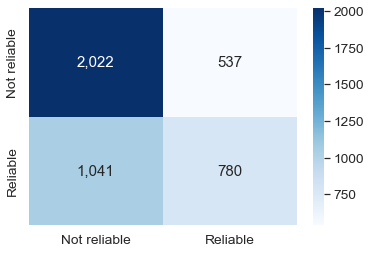

In [44]:
rf = RandomForestClassifier( random_state=13 )
rf.fit( X_train, y_train )
rf_pred = rf.predict( X_valid )
ml_metrics( y_valid, rf_pred, 'Random Forest' )

In [45]:
# Cross Validation
rf = RandomForestClassifier( random_state=13 )
rf_cv = cross_validation( rf, X_train, y_train, 'Random Forest' )
rf_cv

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.64+/-0.01,0.6+/-0.02,0.42+/-0.01,0.49+/-0.01


## 7.9. Compare Model Performance

In [64]:
modeling_result = pd.concat( [dummy_cv, lr_cv, dt_cv, knn_cv, nb_cv, mlp_cv, rf_cv] )
modeling_result.sort_values( ['Precision', 'Recall'], ascending=False ).reset_index( drop=True )

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.64+/-0.01,0.6+/-0.02,0.42+/-0.01,0.49+/-0.01
1,K-Nearest Neighbors,0.55+/-0.0,0.45+/-0.01,0.39+/-0.03,0.42+/-0.02
2,Logistic Regression,0.54+/-0.02,0.44+/-0.02,0.38+/-0.03,0.41+/-0.02
3,Multilayer Perceptron,0.56+/-0.01,0.44+/-0.01,0.23+/-0.04,0.3+/-0.04
4,Decision Tree,0.52+/-0.01,0.42+/-0.01,0.43+/-0.03,0.43+/-0.02
5,Naive Bayes,0.42+/-0.0,0.42+/-0.0,0.97+/-0.01,0.58+/-0.0
6,Dummy,0.52+/-0.0,0.42+/-0.0,0.43+/-0.0,0.42+/-0.0


# 8.0. Hyperparameter Fine Tuning

In [46]:
params = {'n_estimators':      [500, 1000, 1600, 2000, 2500, 3000, 3500],
          'max_features':      ['auto', 'sqrt'],
          'max_depth':         [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf':  [1, 2, 4],
          'bootstrap':         [True, False],
          'random_state':      [13]
          }


precision2_score = make_scorer( precision_score, labels=[1], average='macro' )

search = RandomizedSearchCV(
        estimator = RandomForestClassifier(),
        param_distributions=params,
        n_iter=10,
        scoring=precision2_score,
        n_jobs=-1,
)

result = search.fit( X_train, y_train )
print( 'Done!' )

Done!


In [47]:
# The best params
result.best_params_

{'random_state': 13,
 'n_estimators': 3000,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

Model: Tuned Model
              precision    recall  f1-score   support

Not reliable       0.66      0.81      0.73      2559
    Reliable       0.60      0.40      0.48      1821

    accuracy                           0.64      4380
   macro avg       0.63      0.61      0.60      4380
weighted avg       0.63      0.64      0.62      4380



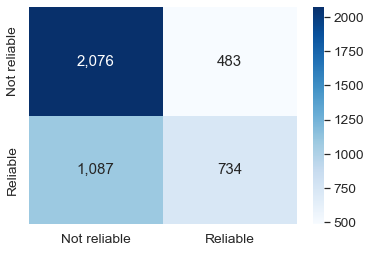

In [48]:
tuned_model = result.best_estimator_
predictions = tuned_model.predict( X_valid )
ml_metrics( y_valid, predictions, 'Tuned Model' )

In [49]:
tuned_model_cv = cross_validation( tuned_model, X_train, y_train, 'Tuned Model' )
tuned_model_cv

,Model,Accuracy,Precision,Recall,F1
0,Tuned Model,0.64+/-0.01,0.61+/-0.02,0.39+/-0.01,0.47+/-0.01


# 9.0. Machine Learning Performance

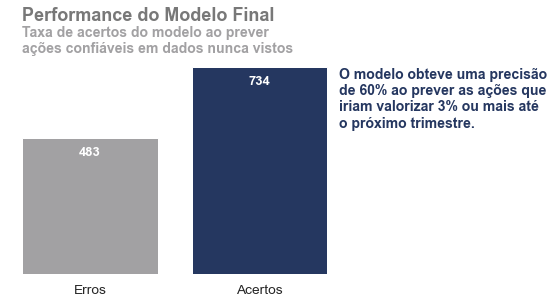

<Figure size 864x432 with 0 Axes>

In [73]:
X_valid['Class'] = y_valid
X_valid['Predictions'] = predictions
aux1 = X_valid[['Class', 'Predictions']].groupby( 'Class' ).sum().reset_index()
aux1['Classifications'] = ['Erros', 'Acertos']

ax = plt.axes()
ax.set_facecolor( "white" )

# colors
gray1, gray2, gray3 = "#CFCDCE", "#A2A1A3", "#787878"
blue1, blue2 = "#8db7eb", "#253760"

# font
plt.rcParams['font.family'] = 'sans-serif'

# colors
colors = [gray2, blue2]

# remove grids
ax.spines['right'].set_visible( False )
ax.spines['left'].set_visible( False )
ax.spines['top'].set_visible( False )
ax.spines['bottom'].set_visible( False )

# # remover eixo y
plt.gca().axes.get_yaxis().set_visible( False )

# # remover xticks do eixo x
plt.tick_params(
    axis='both',         
    which='both',     
    bottom=False,      
    top=False,         
    labelbottom=True )

bars = plt.bar( x='Classifications', height='Predictions', data=aux1,  color=colors )

#criar função para dar labels automaticamente
def autolabel( bars ):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
                        height,
                        xy=( bar.get_x() + bar.get_width()/2,  height ),
                        xytext=( 0, -20 ),  # offset
                        textcoords="offset points",
                        ha='center',
                        va='bottom',
                        fontsize=13,
                        color="white",
                        weight='bold'
                    )
        
# plotar labels dentro das barras
autolabel( bars )

# plotar título
plt.text( -0.40, 900, 'Performance do Modelo Final',
         fontsize=18, 
         color=gray3,
         weight='bold' )

# plotar subtitulo
plt.text( -0.40, 882,
         "Taxa de acertos do modelo ao prever\n"
         "ações confiáveis em dados nunca vistos",
         verticalalignment="top",
         fontsize=14,
         color=gray2,
         weight='bold' )

# plotar anotações do resultado da campanha
plt.text( 1.47, 734,
         "O modelo obteve uma precisão \n"
         "de 60% ao prever as ações que\n"
         "iriam valorizar 3% ou mais até\n"
         "o próximo trimestre.",
         verticalalignment="top",
         fontsize=14,
         color=blue2,
         weight='bold' )

plt.figure( figsize=( 12, 6 ) )

plt.savefig( 'img/final_performance.png' )

# plotar o gráfico
plt.tight_layout()
plt.show()

# 10.0. Deploy Model to Production

In [8]:
# Saving the classification model
# pickle.dump( tuned_model, open( 'model/tuned_model.pkl', 'wb' ) )

## 10.1. Preparation

In [387]:
import pickle
import pandas as pd
import numpy  as np

class Preparation( object ):
    def __init__( self ):
        self.home_path = ''
        self.scaler = pickle.load( open( self.home_path + 'parameter/scaler.pkl', 'rb' ) )
    
    def data_cleaning( self, df1 ):
        df1.fillna( 0, inplace=True )
        return df1
    
    def feature_engineering( self, df2 ):
        # Liquidez Corrente
        df2['Liquidez Corrente'] = df2[['Ativo Circulante', 'Passivo Circulante']].apply( lambda x: 0 if x['Passivo Circulante'] == 0 
                                                                        else x['Ativo Circulante'] / x['Passivo Circulante'], axis=1 )
        # LPA
        df2['LPA'] = df2['Lucro/Prejuízo do Período'] / df2['quantity'] 

        # P/L
        df2['P/L'] = df2[['Adj Close', 'LPA']].apply( lambda x: 0 if x['LPA'] == 0 else x['Adj Close'] / x['LPA'], axis=1 )

        # VPA
        df2['VPA'] = df2['Patrimônio Líquido'] / df2['quantity']

        # P/VP 
        df2['P/VP'] = df2[['Adj Close', 'VPA']].apply( lambda x: 0 if x['VPA'] == 0 else x['Adj Close'] / x['VPA'], axis=1 )

        # EBIT - NAO TEM!!
        df2['EBIT'] = df2['Receita Líquida de Vendas e/ou Serviços'] - df2['Custo de Bens e/ou Serviços Vendidos'] - ( df2['Despesas Com Vendas'] + df2['Despesas Gerais e Administrativas'] )

        # EV/EBIT - NAO TEM!!!!
        df2['EV/EBIT'] = df2[['Adj Close', 'quantity', 'Empréstimos e Financiamentos_1', 'Ativo Circulante', 'EBIT']].apply( lambda x: 0 
                                                            if x['EBIT'] == 0 else ( ( x['Adj Close'] * x['quantity'] ) 
                                                                                    + ( x['Empréstimos e Financiamentos_1'] 
                                                                                    - x['Ativo Circulante'] ) ) 
                                                                                    / x['EBIT'] , axis=1 )
        # NOPLAT - NAO TEM!!!!
        df2['NOPLAT'] = df2['EBIT'] - df2['IR Diferido']

        # ROIC - NAO TEM!!!!
        df2['ROIC'] = df2[['NOPLAT', 'Investimentos']].apply( lambda x: 0 if x['Investimentos'] == 0 
                                                                          else x['NOPLAT'] / x['Investimentos'], axis=1 )

        # ROE
        df2['ROE'] = df2[['Reservas de Lucros', 'Patrimônio Líquido']].apply( lambda x: 0 
                                                        if x['Patrimônio Líquido'] == 0 
                                                        else x['Reservas de Lucros'] / x['Patrimônio Líquido'], axis=1 )

        # Pay-Out
        df2['Pay-Out'] = df2[['Dividendos e JCP a Pagar', 'Lucro/Prejuízo do Período']].apply( lambda x: 0 
                                           if x['Lucro/Prejuízo do Período'] == 0 
                                           else ( x['Dividendos e JCP a Pagar'] / x['Lucro/Prejuízo do Período'] ) * 100, axis=1 )

        # Dividend Yield
        df2['Dividend Yield'] = ( ( df2['Dividendos e JCP a Pagar'] / df2['quantity'] ) / df2['Adj Close'] ) * 100

        # Marg. Ebit - NAO TEM!!!!
        df2['MargEbit'] = df2[['EBIT', 'Receita Líquida de Vendas e/ou Serviços']].apply( lambda x: 0 
                                                                if x['Receita Líquida de Vendas e/ou Serviços'] == 0 
                                                                else x['EBIT'] / x['Receita Líquida de Vendas e/ou Serviços'], axis=1 )

        # Marg. Liquida 
        df2['MargLiquida'] = df2[['Lucro/Prejuízo do Período', 'Receita Líquida de Vendas e/ou Serviços']].apply( lambda x: 0 
                                          if x['Receita Líquida de Vendas e/ou Serviços'] == 0 
                                          else x['Lucro/Prejuízo do Período'] / x['Receita Líquida de Vendas e/ou Serviços'], axis=1 )

        # P/Ebit 
        df2['P/Ebit'] = df2[['Adj Close', 'EBIT']].apply( lambda x: 0 if x['EBIT'] == 0 else x['Adj Close'] / x['EBIT'], axis=1 )

        # PSR
        df2['PSR'] = df2[['Adj Close', 'Receita Líquida de Vendas e/ou Serviços', 'quantity']].apply( lambda x: 0 
                                        if x['Receita Líquida de Vendas e/ou Serviços'] == 0 
                                        else x['Adj Close'] / ( x['Receita Líquida de Vendas e/ou Serviços'] / x['quantity'] ), axis=1 )

        # P/Ativos
        df2['P/Ativos'] = df2[['Adj Close', 'Ativo Total', 'quantity']].apply( lambda x: 0 if x['Ativo Total'] == 0 
                                                                    else x['Adj Close'] / ( x['Ativo Total'] / x['quantity'] ), axis=1 )

        # Giro do Ativo Total
        df2.loc[:, 'GA'] = df2[['Receita Líquida de Vendas e/ou Serviços', 'Ativo Total']].apply( lambda x: 0 if x['Ativo Total'] == 0
                                                          else x['Receita Líquida de Vendas e/ou Serviços'] / x['Ativo Total'], axis=1 )

        # ROA - Retorno do Ativo Total
        df2.loc[:, 'ROA'] = df2[['Lucro/Prejuízo do Período', 'Ativo Total']].apply( lambda x: 0 if x['Ativo Total'] == 0
                                                                         else  x['Lucro/Prejuízo do Período'] / x['Ativo Total'], axis=1 )
        return df2
    
    def data_filtering( self, df3 ):
        df3 = df3.loc[ ( df3['Company'] != 'MMAQ3' ) & ( df3['Company'] != 'MMAQ4' ) &
               ( df3['Company'] != 'VSPT3' ) & ( df3['Adj Close'] > 0 ) ]   
        
        df3 = df3.drop( ['Perc', 'quantity', 'Adj Close', 'Class'], axis=1 )
        
        return df3
    
    def transform_to_percentage_changes( self, df4 ):

        for column in df4:
            if column == 'Company':
                continue

            conditions = [
                ( df4[column].shift( 1 ) == 0 ) & ( df4[column] > 0 ),
                ( df4[column].shift( 1 ) == 0 ) & ( df4[column] < 0 ),
                ( df4[column].shift( 1 ) == 0 ) & ( df4[column] == 0 )
            ]

            values = [1, -1, 0]

            df4[column] = np.select( conditions, values, default=df4[column].diff() / df4[column].abs().shift() )

        return df4.drop( df4.index[0], axis=0 )
    
    def data_preparation( self, df5 ):
        df5.drop( 'Company', axis=1, inplace=True )
        df5 = pd.DataFrame( self.scaler.transform( df5 ), index=df5.index, columns=df5.columns )
        
        cols_selected = ['Ativo Total',
                         'Caixa e Equivalentes de Caixa',
                         'Imobilizado',
                         'Passivo Total',
                         'Patrimônio Líquido',
                         'Lucros/Prejuízos Acumulados',
                         'Financeiras',
                         'P/L',
                         'VPA',
                         'P/VP',
                         'MargEbit',
                         'P/Ativos']

        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        original_data.drop( 0, axis=0, inplace=True )
        
        # join pred into the original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records' )

## 10.2. API Handler

In [ ]:
import os
import pickle
import pandas              as pd
from   flask               import Flask, request, Response
from   investBot.InvestBot import Preparation

# loading model
model = pickle.load( open( 'model/tuned_model.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/investbot/predict', methods=['POST'] )
def invest_bot():
    test_json = request.get_json()
    
    if test_json: # there is data
        test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # Instatiate
        pipeline = Preparation()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )

        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data_filtering
        df3 = pipeline.data_filtering( df2 )

        # transform to percentage changes
        df4 = pipeline.transform_to_percentage_changes( df3 )

        # data preparation
        df5 = pipeline.data_preparation( df4 )

        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df5 )

        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    port = os.environ.get( 'PORT', 5000 )
    app.run( host='0.0.0.0', port=port )

## 10.3. API Tester

In [410]:
import requests

test_dataset = pd.read_csv( 'data/Fundamentals.csv' )

# loading test dataset
test_dataset = test_dataset[27:29]

# Reading the dataset of the number of papers available
df_qnt = pd.read_csv( 'Data/quantity.csv' )

# merge
test_dataset = pd.merge( test_dataset, df_qnt, how='inner', on=['Company'] )

# change data type
test_dataset['quantity'] = test_dataset['quantity'].astype( 'int64' )

# convert DataFrame to json
data = json.dumps( test_dataset.to_dict( orient='records' ) )

In [411]:
# API call
# url = 'http://0.0.0.0:5000/investbot/predict'
url = 'https://investbot-model.herokuapp.com/investbot/predict'
header = {'Content-type': 'application/json' }
data = data

r = requests.post( url, data = data, headers = header )
print( f'Status Code {r.status_code}' )

Status Code 200


In [412]:
result = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
result

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,Ativo Realizável a Longo Prazo,Aplicações Financeiras Avaliadas a Valor Justo,Aplicações Financeiras Avaliadas ao Custo Amortizado,Contas a Receber,Estoques,Ativos Biológicos,Tributos Diferidos_1,Despesas Antecipadas,Créditos com Partes Relacionadas,Outros Ativos Não Circulantes,Investimentos,Imobilizado,Intangível,Diferido,Passivo Total,Passivo Circulante,Obrigações Sociais e Trabalhistas,Fornecedores,Obrigações Fiscais,Empréstimos e Financiamentos_1,Passivos com Partes Relacionadas_1,Dividendos e JCP a Pagar,Outros_1,Provisões_1,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados_1,Passivo Não Circulante,Empréstimos e Financiamentos,Passivos com Partes Relacionadas,Outros,Tributos Diferidos,Adiantamento para Futuro Aumento Capital_1,Provisões,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados,Lucros e Receitas a Apropriar,Participação dos Acionistas Não Controladores,Patrimônio Líquido,Capital Social Realizado,Reservas de Capital,Reservas de Reavaliação,Reservas de Lucros,Lucros/Prejuízos Acumulados,Ajustes de Avaliação Patrimonial,Ajustes Acumulados de Conversão,Outros Resultados Abrangentes,Adiantamento para Futuro Aumento Capital,Receita Líquida de Vendas e/ou Serviços,Custo de Bens e/ou Serviços Vendidos,Resultado Bruto,Despesas Com Vendas,Despesas Gerais e Administrativas,Perdas pela Não Recuperabilidade de Ativos,Outras Receitas Operacionais,Outras Despesas Operacionais,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Lucro/Prejuízo do Período,Adj Close,Company,Perc,Class,quantity,Liquidez Corrente,LPA,P/L,VPA,P/VP,EBIT,EV/EBIT,NOPLAT,ROIC,ROE,Pay-Out,Dividend Yield,MargEbit,MargLiquida,P/Ebit,PSR,P/Ativos,GA,ROA,prediction
0,75101184.00,19241015.30,6974584.83,1033758.02,2897700.10,4377888.77,0.00,1394295.04,701361.98,1861427.97,5859774.98,0.00,84416.00,0.00,0.00,0.00,2791227.90,100646.00,0.00,2883484.93,146156.00,16542042.11,33312196.61,0,75101184.00,21767886.85,615576.00,8199044.10,3042099.97,994518.02,0.00,498622.02,8276885.95,141140.00,0.00,7220915.20,1696525.06,0.00,3051086.08,1896973.06,0,576331.01,0.00,0.00,1794361.98,44318020.99,57614139.39,54986125.31,0.00,2904090.88,1867697.02,-73054035.97,0.00,0.00,0,10768792.58,-3613808.13,7154984.96,-2698832.90,-521515.01,0.00,508894.02,-49918.00,2409.00,-481695.01,290249.98,-771945.02,3914327.04,-923454.98,-28029.00,2810662.91,14.95,ABEV3,0.03,1,15744500000,0.88,0.00,83724.35,0.00,5309.82,17602948.61,13367.23,17630977.61,120.63,0.07,17.74,0.00,1.63,0.26,0.00,21852.12,3133.39,0.14,0.04,1


In [413]:
if result.loc[0, 'prediction']:
    print( f'The paper {result.loc[0, "Company"]} will yield 3% or more until the next quarter' )
else:
    print( f'The paper {result.loc[0, "Company"]} will not yield 3% or more until the next quarter' )

The paper ABEV3 will yield 3% or more until the next quarter


In [407]:
df = pd.DataFrame()
for i in list( test_dataset.Company.unique() ):
    df = df.append(test_dataset[test_dataset['Company'] == i][-1:])

In [409]:
df[df.Class == 1]

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,Ativo Realizável a Longo Prazo,Aplicações Financeiras Avaliadas a Valor Justo,Aplicações Financeiras Avaliadas ao Custo Amortizado,Contas a Receber,Estoques,Ativos Biológicos,Tributos Diferidos_1,Despesas Antecipadas,Créditos com Partes Relacionadas,Outros Ativos Não Circulantes,Investimentos,Imobilizado,Intangível,Diferido,Passivo Total,Passivo Circulante,Obrigações Sociais e Trabalhistas,Fornecedores,Obrigações Fiscais,Empréstimos e Financiamentos_1,Passivos com Partes Relacionadas_1,Dividendos e JCP a Pagar,Outros_1,Provisões_1,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados_1,Passivo Não Circulante,Empréstimos e Financiamentos,Passivos com Partes Relacionadas,Outros,Tributos Diferidos,Adiantamento para Futuro Aumento Capital_1,Provisões,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados,Lucros e Receitas a Apropriar,Participação dos Acionistas Não Controladores,Patrimônio Líquido,Capital Social Realizado,Reservas de Capital,Reservas de Reavaliação,Reservas de Lucros,Lucros/Prejuízos Acumulados,Ajustes de Avaliação Patrimonial,Ajustes Acumulados de Conversão,Outros Resultados Abrangentes,Adiantamento para Futuro Aumento Capital,Receita Líquida de Vendas e/ou Serviços,Custo de Bens e/ou Serviços Vendidos,Resultado Bruto,Despesas Com Vendas,Despesas Gerais e Administrativas,Perdas pela Não Recuperabilidade de Ativos,Outras Receitas Operacionais,Outras Despesas Operacionais,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Lucro/Prejuízo do Período,Adj Close,Company,Perc,Class
86,286.00,38.00,0.00,0.00,2.00,0.00,0.00,22.00,8.00,6.00,53.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.00,185.00,0,286.00,15862.00,1814.00,1003.00,426.00,0.00,12555.00,0.00,0.00,64.00,0.00,1707.00,0.00,0.00,0.00,0.00,0,1707.00,0.00,0.00,0.00,-17283.00,33860.00,4332.00,0.00,0.00,-55475.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,-801.00,0.00,0.00,0.00,0.00,258.00,340.00,-82.00,-543.00,0.00,0.00,-543.00,1.10,ADHM3,0.37,1
394,5067043.84,2699348.99,867113.02,0.00,799681.02,839873.98,0.00,113904.00,26243.00,52534.00,694568.00,12159.00,0.00,0.00,776.00,0.00,0.00,98003.00,0.00,0.00,2430.00,1072420.99,598275.97,0,5067043.84,1303769.98,162718.00,410820.00,67348.00,174350.00,0.00,846.00,481128.02,6560.00,0.00,532315.01,68002.00,0.00,395284.00,52351.00,0,16678.00,0.00,0.00,63185.00,3167774.10,1500000.00,141718.00,0.00,1473634.94,0.00,0.00,52186.00,235.00,0,1095318.02,-483118.02,612200.00,-367241.98,-46621.00,0.00,17629.00,-32573.00,0.00,-44622.00,-19537.00,-25085.00,138771.01,-29384.00,10299.00,107456.00,49.64,ALPA4,0.05,1
1132,8785477.63,2558051.07,1785283.97,3046.00,0.00,0.00,0.00,0.00,0.00,0.00,6377.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6377.00,6221049.86,0.00,0.00,0,8785477.63,1570227.97,344719.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,273976.99,273976.99,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,6941273.09,5646768.13,0.00,0.00,1311186.05,0.00,-16681.00,0.00,0.00,0,0.00,0.00,0.00,3864.00,0.00,0.00,0.00,0.00,0.00,622742.02,622742.02,0.00,1071920.90,-25721.00,0.00,0.00,14.23,BBSE3,0.05,1
1255,17627666.43,12061518.85,4767587.84,1574365.06,2309649.92,1384450.05,485024.99,1066628.99,0.00,473812.00,709369.02,0.00,0.00,0.00,0.00,0.00,0.00,428448.99,0.00,0.00,50450.00,4044253.95,762073.98,0,17627666.43,7504130.05,223372.00,2817245.95,113501.00,2255826.94,0.00,0.00,2094183.94,0.00,0.00,9700611.07,9395345.41,0.00,114844.00,149891.01,0,40531.00,0.00,0.00,0.00,422924.99,1311682.05,-124497.00,48292.00,153438.00,376990.02,0.00,-1342979.97,0.00,0,6287817.22,-5244526.08,1043291.01,-377945.98,-218100.00,0.00,12663.00,0.00,0.00,-322271.01,219932.00,-542203.01,137636.99,-29459.00,8492.00,116670.00,9.05,BEEF3,0.12,1
1